In [92]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [93]:
data = pd.read_csv('./data/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [108]:
address2country = pd.read_csv('./data/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:

merged_data = pd.merge(data, address2country, 
                       left_on='ip_address', 
                       right_on='lower_bound_ip_address', 
                       how='left')

merged_data.head() 

# Afficher les colonnes avec uniquement des NaN
nan_columns = merged_data.columns[merged_data.isna().all()]
print("Colonnes entièrement remplies de NaN :")
print(nan_columns)



Colonnes entièrement remplies de NaN :
Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')


In [96]:
merged_data['time_diff'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds()

In [97]:
merged_data['unique_users_per_device'] = merged_data.groupby('device_id')['user_id'].transform('nunique')


In [98]:
# Calculer le nombre d'utilisateurs uniques par adresse IP
merged_data['unique_users_per_ip'] = merged_data.groupby('ip_address')['user_id'].transform('nunique')


In [99]:
merged_data['signup_day'] = merged_data['signup_time'].dt.day
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week


In [100]:
merged_data['purchase_day'] = merged_data['purchase_time'].dt.day
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week


In [101]:
merged_data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,lower_bound_ip_address,upper_bound_ip_address,country,time_diff,unique_users_per_device,unique_users_per_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,NaN,NaN,NaN,4506682.0,1,1,24,9,18,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,NaN,NaN,NaN,17944.0,1,1,7,23,8,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,NaN,NaN,NaN,1.0,12,12,1,1,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,NaN,NaN,NaN,492085.0,1,1,28,18,4,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,NaN,NaN,NaN,4361461.0,1,1,21,30,9,37


In [102]:
features = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'unique_users_per_device', 'unique_users_per_ip']
target = 'class'

In [103]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(merged_data, test_size=0.3, random_state=42)

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

Training set shape: (105778, 21)
Test set shape: (45334, 21)


In [104]:
# Encoder les colonnes catégorielles
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# S'assurer que les colonnes sont identiques dans les ensembles de train et de test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire avec le modèle sur les données de test
y_pred = rf_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.99      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



1. feature time_diff (0.28539586502825426)
2. feature unique_users_per_ip (0.15219532572234493)
3. feature unique_users_per_device (0.1497151944352809)
4. feature purchase_week (0.1481059696133991)
5. feature signup_week (0.056123435983581604)
6. feature purchase_value (0.0480717078513589)
7. feature purchase_day (0.045858841643974975)
8. feature age (0.04134174533095969)
9. feature signup_day (0.03749523313996357)
10. feature sex_M (0.007284580800169044)
11. feature browser_IE (0.005832168958983197)
12. feature browser_Safari (0.005448802324998867)
13. feature source_SEO (0.005165177470367996)
14. feature browser_FireFox (0.005128057214879422)
15. feature source_Direct (0.0048440950942642315)
16. feature browser_Opera (0.001993799387219213)


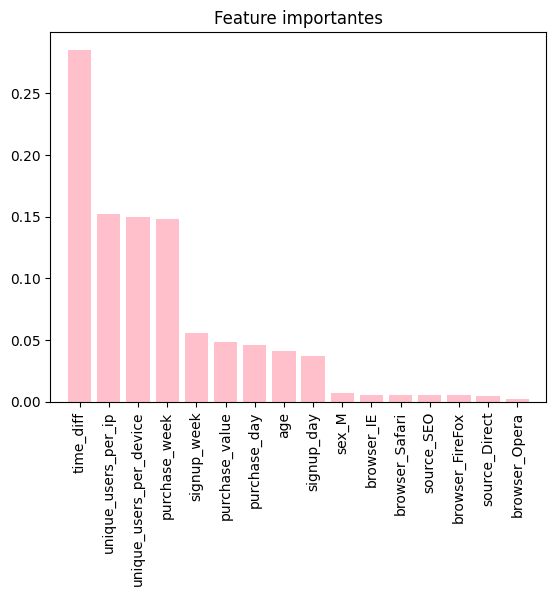

In [105]:
## NOTE: L'importance des features n'est pas la même que dans le cours du professeur, cependant le résultat est très sensiblement le même
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")


plt.title("Feature importantes")
plt.bar(range(X_train.shape[1]), importances[indices], color="pink")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

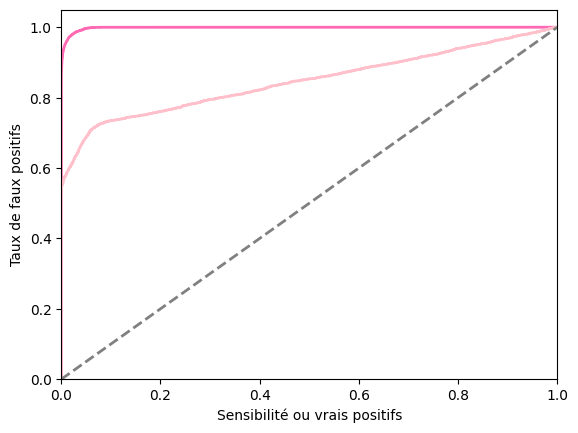

In [106]:

y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)


y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, color='hotpink', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='pink', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Sensibilité ou vrais positifs')
plt.ylabel('Taux de faux positifs')
plt.show()